In [15]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [16]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

In [17]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX05112024_angle_test"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [18]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [19]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[ 3.24877510e-01, -3.89551697e-01,  9.68527256e+00,
        -1.81914749e-01,  1.47795159e-01,  9.72143824e-01],
       [ 3.45595814e-01,  3.43967888e-02,  9.85193375e+00,
        -1.76371656e-01,  4.21403260e-02,  9.83421187e-01],
       [ 3.75797548e-01,  4.00105590e-01,  1.00530364e+01,
        -1.64567222e-01, -7.56287972e-02,  9.83462208e-01],
       [-4.71633214e-02, -3.75448937e-01,  9.84101617e+00,
        -7.41786544e-02,  1.42562127e-01,  9.87002314e-01],
       [ 3.30319486e-03,  2.01950448e-03,  1.00046096e+01,
        -6.59619242e-02,  3.19844661e-02,  9.97309390e-01],
       [ 4.85545163e-02,  3.52866548e-01,  1.01996003e+01,
        -5.35123806e-02, -8.84704231e-02,  9.94640342e-01],
       [-3.87182230e-01, -3.86607609e-01,  1.00254820e+01,
         4.60210147e-02,  1.37050179e-01,  9.89494474e-01],
       [-3.27063691e-01, -1.49919674e-02,  1.01831567e+01,
         5.73338706e-02,  2.49275747e-02,  9.98043808e-01],
       [-2.72165373e-01,  3.11455173e-01,  1.037

In [20]:
actang = [np.array([0, 0, 0])]
for y in range(3):
    for z in range(3):
        add = np.array([np.sin(np.deg2rad(5*y-5)), np.sin(np.deg2rad(5*z-5)), np.cos(np.deg2rad(5*y-5))*np.cos(np.deg2rad(5*z-5))])
        actang = np.append(actang, [add], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang
np.sum(actang**2)

9.000230804368536

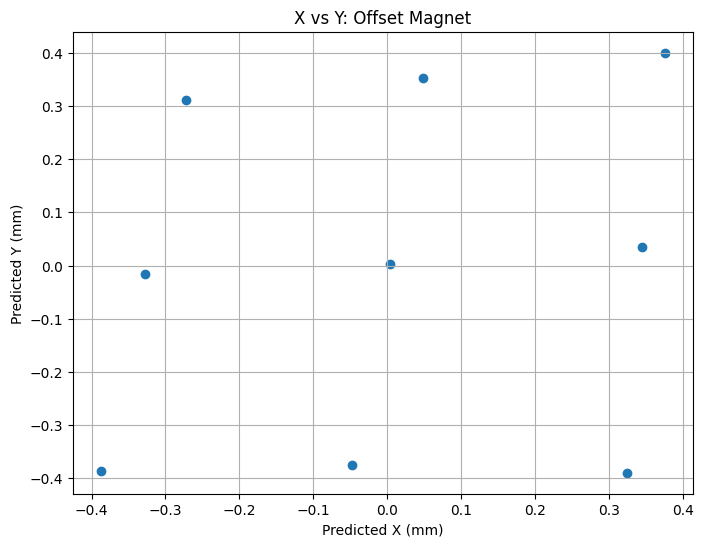

[ 0.32487751  0.34559581  0.37579755 -0.04716332  0.00330319  0.04855452
 -0.38718223 -0.32706369 -0.27216537]
[-0.3895517   0.03439679  0.40010559 -0.37544894  0.0020195   0.35286655
 -0.38660761 -0.01499197  0.31145517]
[ 9.68527256  9.85193375 10.05303638  9.84101617 10.00460963 10.19960027
 10.02548198 10.18315674 10.37004226]
[ 9.69854631  9.85805347 10.06801116  9.84828846 10.00461038 10.20581785
 10.04040161 10.18841875 10.37828766]


In [24]:
dispx = np.array(loc_pred[:,0])
dispy = np.array(loc_pred[:,1])
dispz = np.array(loc_pred[:,2])
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

plt.figure(figsize=(8, 6))
plt.scatter(dispx, dispy, label='Predicted Location')
plt.xlabel('Predicted X (mm)')
plt.ylabel('Predicted Y (mm)')
plt.title('X vs Y: Offset Magnet')
#plt.legend()
plt.grid(True)
plt.show()

print(dispx)
print(dispy)
print(dispz)
print(disp)

In [30]:
x1, z1 = loc_pred[0,0], loc_pred[0,2]
x2, z2 = loc_pred[3,0], loc_pred[1,2]
x3, z3 = loc_pred[6,0], loc_pred[2,2]
print("Radius of the circle about the x-axis:", circle_radius(x1, z1, x2, z2, x3, z3))

y1 = loc_pred[0,1]
y2 = loc_pred[1,1]
y3 = loc_pred[2,1]
print("Radius of the circle about the y-axis:", circle_radius(y1, z1, y2, z2, y3, z3))

Radius of the circle about the x-axis: 3.555386197163787
Radius of the circle about the y-axis: 3.4065576698026057
